## Load imports and read data

In [1]:
import pandas as pd
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

df = pl.read_csv('../input_data/cbb_postseason_wins.csv')
print(df.shape)
display(df.head())

(748, 25)


TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,POSTSEASON_WINS
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64
"""North Carolina""","""ACC""",40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,"""2ND""",1,2016,5
"""Wisconsin""","""B10""",40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,"""2ND""",1,2015,5
"""Michigan""","""B10""",40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,"""2ND""",3,2018,5
"""Texas Tech""","""B12""",38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,"""2ND""",3,2019,5
"""Gonzaga""","""WCC""",39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,"""2ND""",1,2017,5


## Get the average wins by seed as a baseline for prediction accuracy

In [5]:
avg_wins = (df
    .group_by('SEED').agg(pl.col('POSTSEASON_WINS').mean())
    .sort('SEED')
)
avg_wins

SEED,POSTSEASON_WINS
i64,f64
1,3.113636
2,2.090909
3,1.8
4,1.72093
5,1.136364
…,…
12,0.456522
13,0.222222
14,0.159091


## Prep data:
* We currently have non-numeric data: TEAM, CONF, POSTSEASON
* POSTSEASON has already been translated to POSTSEASON_WINS 
* We will not use team as the same teams won't always make it and we can't use it to predict for a new team
* We can use conference though as the winner of each conference makes the tournament each year, so there will always be a representative
    * Possible in the future there is realignment and changes so we should potentially rethink if that happens
* We will one-hot encode the conferences to make them numerical

In [28]:
df_prep = (df
           .select(pl.all().exclude('TEAM', 'POSTSEASON'))
           .to_dummies(['CONF'])
)

cols = df_prep.columns
df_prep = (
    df_prep.with_columns(Col = cols)
)
df_prep

CONF_A10,CONF_ACC,CONF_AE,CONF_ASun,CONF_Amer,CONF_B10,CONF_B12,CONF_BE,CONF_BSky,CONF_BSth,CONF_BW,CONF_CAA,CONF_CUSA,CONF_Horz,CONF_Ivy,CONF_MAAC,CONF_MAC,CONF_MEAC,CONF_MVC,CONF_MWC,CONF_NEC,CONF_OVC,CONF_P12,CONF_Pat,CONF_SB,CONF_SC,CONF_SEC,CONF_SWAC,CONF_Slnd,CONF_Sum,CONF_WAC,CONF_WCC,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR,POSTSEASON_WINS,Col
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,list[str]
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,18.2,40.7,30.0,32.3,30.4,53.9,44.6,32.7,36.2,71.7,8.6,1,2016,5,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3,1,2015,5,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,19.5,25.5,24.9,30.7,30.0,54.7,46.8,35.2,33.2,65.9,6.9,3,2018,5,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,22.8,27.4,28.7,32.9,36.6,52.8,41.9,36.5,29.7,67.5,7.0,3,2019,5,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,17.1,30.0,26.2,39.0,26.9,56.3,40.0,38.2,29.0,71.5,7.7,1,2017,5,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,17,102.9,105.8,0.4193,53.9,52.3,16.8,18.6,20.7,28.6,30.7,37.0,53.4,54.1,36.4,32.6,68.5,-12.6,16,2024,0,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,22,108.3,114.0,0.3559,53.4,52.0,15.8,13.5,27.5,31.2,31.7,25.9,52.5,52.2,36.5,34.5,66.0,-6.8,16,2024,0,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,18,104.5,112.9,0.2913,52.0,50.9,21.4,16.7,33.4,30.7,42.2,39.1,49.2,50.8,37.5,34.0,67.7,-12.1,16,2024,0,"[""CONF_A10"", ""CONF_ACC"", … ""POSTSEASON_WINS""]"


In [32]:
df_prep2 = pl.DataFrame(data = df_prep.columns)
df_prep2

column_0
str
"""CONF_A10"""
"""CONF_ACC"""
"""CONF_AE"""
"""CONF_ASun"""
"""CONF_Amer"""
…
"""WAB"""
"""SEED"""
"""YEAR"""


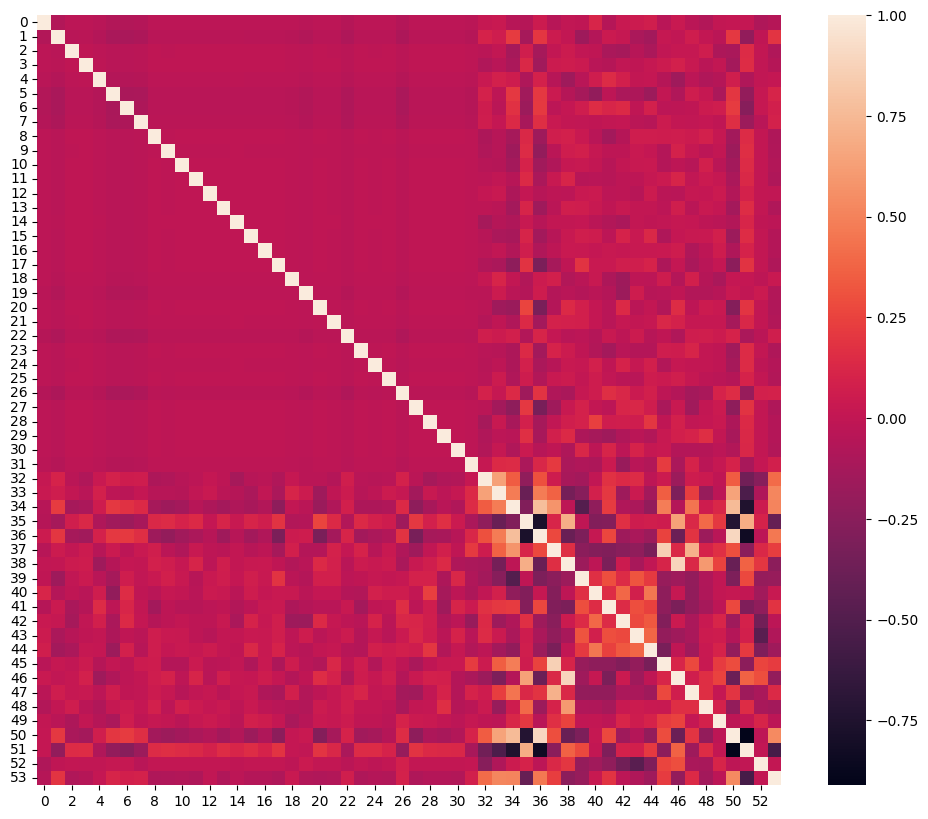

In [21]:
df_corr = df_prep.corr()
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=False, fmt='.2f')
plt.show()

## TO DO:
* Avg wins by seed
* Correlation matrix - figure out which variables are highly correlated and might be confounding
* Linear Regression
* Non Linear regression
* NN
* KNN
* Decision tree
* Random Forest
* Single variable predictions - will a team make the final four (equivalent of 4 wins)
* Multivariable prediction - how many games do we expect a team to win
